In [1]:
import pandas as pd
import numpy as np
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from ipynb.fs.defs.nb3 import scatterRevenues, KFold, plotSummedRevenues, scatterErrorSummedRevenues, getOverallError, plotFinalResults
from ipynb.fs.defs.nb4 import getDataFirstRevenue, createPseudoRevenues, createSumPredictedPseudoRevenue, getPseudoRevenues, getMinMax, errorL1, trainModelLR, applyMinMax, trainAllCampaignsLR

plt.rcParams["figure.figsize"] = [10, 5]

validDf = pd.read_csv("../data/valid_dataset_minimal.csv").drop(columns=["Unnamed: 0"])
campaigns = validDf["Campaign"].unique()
validDf["Date"] = pd.to_datetime(validDf["Date"])
# print(validDf.head(10))
print(validDf.dtypes)

Date                     datetime64[ns]
Source / Medium                  object
Campaign                         object
Device Category                  object
Users                             int64
Sessions                          int64
Bounces                           int64
Transactions                      int64
Cost                            float64
Revenue                         float64
Product Detail Views              int64
Product Adds To Cart              int64
Product Checkouts                 int64
Session Duration                 object
Total Unique Searches             int64
Pageviews                        object
New Users                         int64
Impressions                       int64
Clicks                           object
Session Duration (s)            float64
Medium                           object
dtype: object


### 1. Bucketing for one-week (at least) assumption

In [2]:
from datetime import timedelta

def getCampaignOneWeekRevenue(df):
    df["Bucket Index"] = 0
    minDate = df["Date"].min() - df["Date"].min().dayofweek * timedelta(days=1)
    # Get the number of weeks difference between each date and first week in the dataset
    df["Bucket Weeks"] = (df["Date"] - minDate).apply(lambda x : int(x.days / 7))
    uniqueDeltas = np.sort(np.unique(df["Bucket Weeks"]))

    bucketIndex = 0
    for i in range(len(uniqueDeltas)):
        weekIx = uniqueDeltas[i]
        where = df["Bucket Weeks"] == weekIx
        items = df[where]
        # Both conditions must apply. Unless we get both some costs and some revenues, we can't complete
        #  the bucket.
        if items["Cost"].sum() > 0 and items["Revenue"].sum() > 0:
            df.loc[where, "Bucket Index"] = bucketIndex
            bucketIndex += 1
            continue
        # We must be careful at "end" buckets, where diff between weeks is larger than 1.
        if i > 0 and uniqueDeltas[i] != uniqueDeltas[i - 1] + 1:
            bucketIndex += 1
        df.loc[where, "Bucket Index"] = bucketIndex
    return df

# Return a new column called "bucket index", which represents on what (Cost, Revenue) bucket each entry goes
# This is unique for all campaigns, so bucket index == 1 for Campaign "A", is a different bucket from bucket
#  index == 1 for Campaign "B". This column is used to train on the same logical data (Bucket, Revenue), and
#  we don't get Costs from same bucket both in train and validation set.
# Other assumptions (like weekly assumption) can update this indexes as they will to provide other logic of
#  implementation for the dataset split.
def getOneWeekRevenue(df):
    newDf = pd.DataFrame(columns=df.columns)
    campaigns = df["Campaign"].unique()
    for campaign in campaigns:
        dfCampaign = df[df["Campaign"] == campaign].reset_index(drop=True)
        newDfCampaign = getCampaignOneWeekRevenue(dfCampaign)
        numBuckets = len(newDfCampaign["Bucket Index"].unique())
        print("Campaign '%s'" % (campaign))
        print(" - Unique weeks: %d" % (len(newDfCampaign["Bucket Weeks"].unique())))
        print(" - (Cost, Revenue) buckets: %d" % (numBuckets))
        if numBuckets < 20:
            print(" - Below 20 buckets, skipping.")
            continue

        revenues = newDfCampaign["Revenue"]
        # print(campaign, np.percentile(revenues, [0.1, 1, 10, 25, 50, 75, 90, 99, 99.5, 99.9, 100]))
        # Clip the revenues to top 99.5%, to eliminate outliers.
        Max = newDfCampaign["Revenue"].max()
        Top99_9 = np.percentile(newDfCampaign["Revenue"], 99.9)
        print(" - Pruning max revenue from %2.3f to %2.3f" % (Max, Top99_9))
        newDfCampaign["Label Revenue"] = np.clip(newDfCampaign["Revenue"], 0, Top99_9)
        newDf = pd.concat([newDf, newDfCampaign], sort=False)      
    return newDf

oneWeekRevenueDf = getOneWeekRevenue(validDf)
print("___________________________________")
print("Original df: %s. Training df: %s" % (validDf.shape, oneWeekRevenueDf.shape))

Campaign 'AW - Accessories'
 - Unique weeks: 143
 - (Cost, Revenue) buckets: 88
 - Pruning max revenue from 1523.180 to 1231.693
Campaign 'AW - Apparel'
 - Unique weeks: 128
 - (Cost, Revenue) buckets: 78
 - Pruning max revenue from 1623.750 to 400.446
Campaign 'Remarketing'
 - Unique weeks: 18
 - (Cost, Revenue) buckets: 7
 - Below 20 buckets, skipping.
Campaign 'AW - Dynamic Search Ads Whole Site'
 - Unique weeks: 121
 - (Cost, Revenue) buckets: 90
 - Pruning max revenue from 2224.430 to 1487.605
Campaign 'AW - Bags'
 - Unique weeks: 57
 - (Cost, Revenue) buckets: 27
 - Pruning max revenue from 284.580 to 236.282
Campaign 'AW - Google Brand'
 - Unique weeks: 64
 - (Cost, Revenue) buckets: 35
 - Pruning max revenue from 627.490 to 412.865
Campaign 'AW - Office'
 - Unique weeks: 55
 - (Cost, Revenue) buckets: 21
 - Pruning max revenue from 1857.000 to 1124.667
Campaign 'AW - YouTube'
 - Unique weeks: 33
 - (Cost, Revenue) buckets: 8
 - Below 20 buckets, skipping.
Campaign 'AW - Drinkwa

In [3]:
trainDf = getPseudoRevenues(oneWeekRevenueDf)
trainDf["Bucket Index"] = trainDf["Bucket Index"].astype(int)

### 1. Just Cost

In [4]:
Stats = getMinMax(trainDf)
from sklearn.linear_model import LinearRegression
models, errors = trainAllCampaignsLR(trainDf, Stats, LinearRegression, features=["Cost"])
display(pd.DataFrame(errors.items(), columns=["Campaign", "Error (L1)"]))

,Campaign,Error (L1)
0,AW - Accessories,32.301508
1,AW - Apparel,4.857611
2,AW - Dynamic Search Ads Whole Site,28.029295
3,AW - Bags,6.114983
4,AW - Google Brand,4.809603
5,AW - Office,5.522282
6,All Products,5.365749


In [5]:
predictedDf = createPseudoRevenues(models, trainDf, Stats, features=["Cost"])
print(predictedDf.shape)

(8264, 27)


In [6]:
sumPredictedDf = createSumPredictedPseudoRevenue(predictedDf)
print(sumPredictedDf.shape)

(8264, 28)


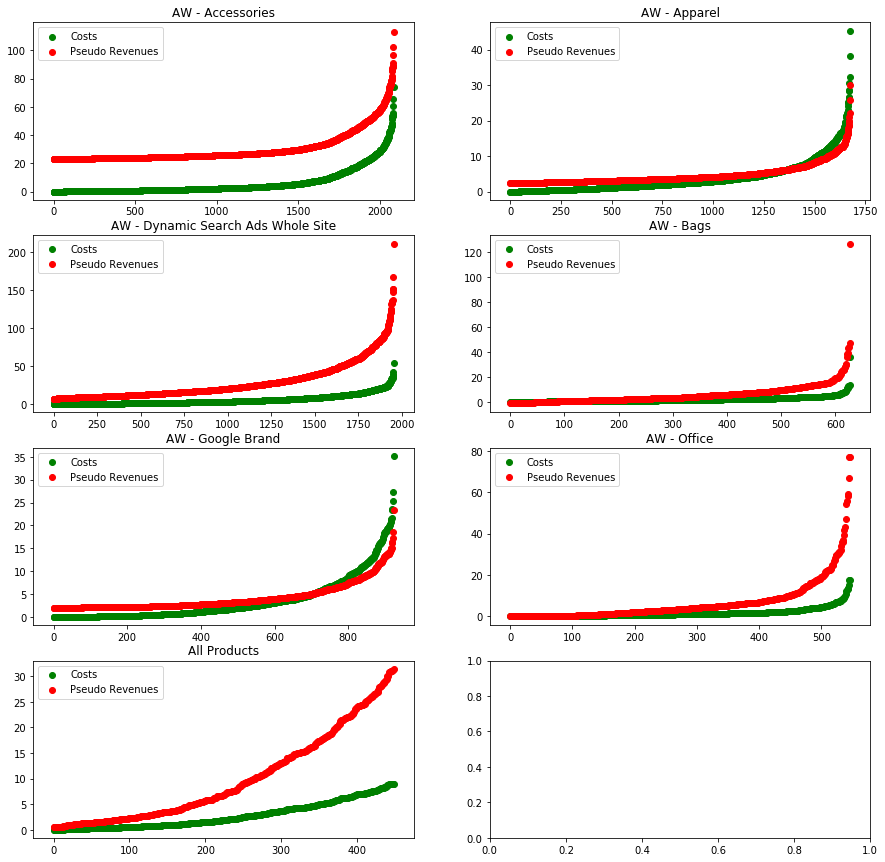

In [7]:
scatterRevenues(sumPredictedDf)

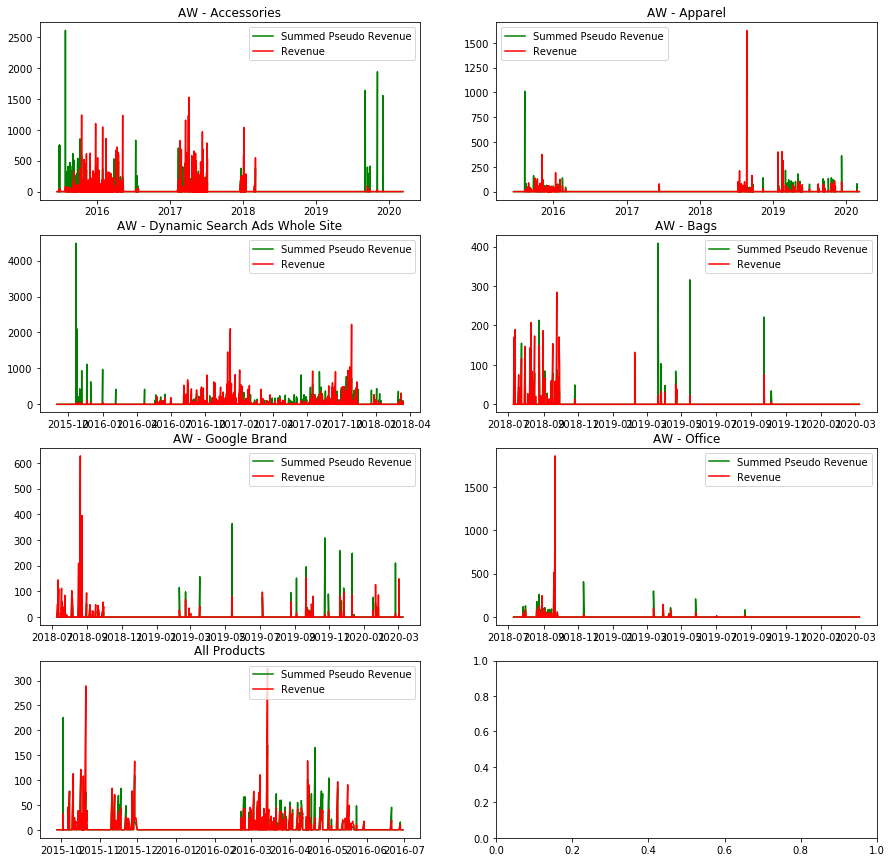

In [8]:
plotSummedRevenues(sumPredictedDf)

In [9]:
LROverallError = getOverallError(sumPredictedDf)
display(LROverallError)

,Campaign,Sum Revenues,Sum Pseudo Revenues,Avg Revenue,Avg Diff Error (L1),Avg Relative (%)
0,AW - Accessories,63700.71,16301.528570,140.930774,114.301 +/- 239.710,44.783167
1,AW - Apparel,9104.17,639.981608,65.972246,59.293 +/- 163.081,47.333822
2,AW - Bags,3721.28,521.000824,71.563077,55.204 +/- 73.319,43.547634
3,AW - Dynamic Search Ads Whole Site,57540.27,16198.146751,150.628979,135.161 +/- 326.032,47.293857
4,AW - Google Brand,4122.77,280.345059,73.620893,70.442 +/- 105.981,48.896618
5,AW - Office,4269.28,411.922611,118.591111,118.610 +/- 299.567,50.004011
6,All Products,4502.51,1639.362263,41.307431,19.662 +/- 34.105,32.248419


# 2. One extra feature

In [10]:
trainDfTwoFeatures = pd.get_dummies(trainDf, columns=["Device Category"])

Stats = getMinMax(trainDfTwoFeatures)
features = ["Cost", "Device Category_desktop", "Device Category_mobile", "Device Category_tablet"]
models, errors = trainAllCampaignsLR(trainDfTwoFeatures, Stats, LinearRegression, features=features)
display(pd.DataFrame(errors.items(), columns=["Campaign", "Error (L1)"]))

predictedDf2F = createPseudoRevenues(models, trainDfTwoFeatures, Stats, features=features)
sumPredictedDf2F = createSumPredictedPseudoRevenue(predictedDf2F)

,Campaign,Error (L1)
0,AW - Accessories,30.552879
1,AW - Apparel,4.809950
2,AW - Dynamic Search Ads Whole Site,28.075978
3,AW - Bags,6.147083
4,AW - Google Brand,4.609129
5,AW - Office,5.523939
6,All Products,5.560391


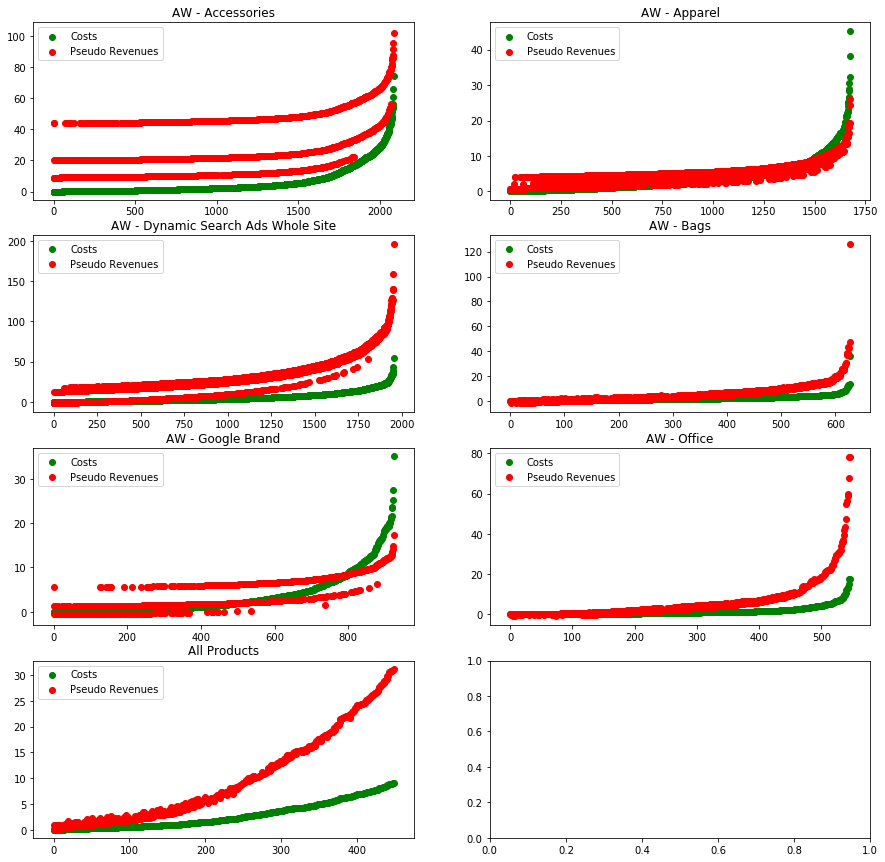

In [11]:
scatterRevenues(sumPredictedDf2F)

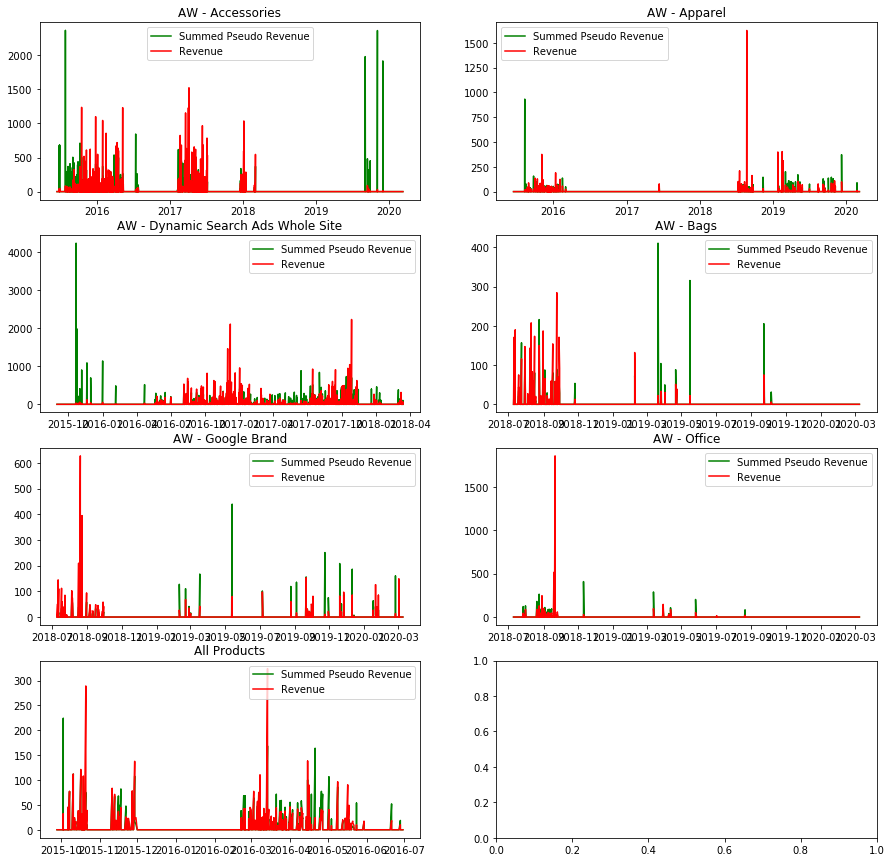

In [12]:
plotSummedRevenues(sumPredictedDf2F)

In [13]:
display(getOverallError(sumPredictedDf2F))

,Campaign,Sum Revenues,Sum Pseudo Revenues,Avg Revenue,Avg Diff Error (L1),Avg Relative (%)
0,AW - Accessories,63700.71,19409.584669,140.930774,114.038 +/- 250.672,44.726345
1,AW - Apparel,9104.17,678.801553,65.972246,58.704 +/- 159.812,47.085051
2,AW - Bags,3721.28,525.081377,71.563077,55.035 +/- 72.971,43.472112
3,AW - Dynamic Search Ads Whole Site,57540.27,17510.651328,150.628979,136.379 +/- 316.882,47.517550
4,AW - Google Brand,4122.77,282.542315,73.620893,67.008 +/- 105.103,47.648736
5,AW - Office,4269.28,411.373647,118.591111,118.693 +/- 299.317,50.021532
6,All Products,4502.51,1643.103669,41.307431,19.817 +/- 34.147,32.420748


In [14]:
trainDfManyFeatures = pd.get_dummies(trainDf, columns=["Device Category"])
for col in trainDfManyFeatures:
    if col == "Bucket Index":
        continue
    try:
        trainDfManyFeatures[col] = trainDfManyFeatures[col].astype(np.float32)
    except Exception:
        pass
Stats = getMinMax(trainDfManyFeatures)

features = ["Cost", "Device Category_desktop", "Device Category_mobile", "Device Category_tablet", \
            "Users", "Sessions", "Bounces", "Transactions", "Product Detail Views", \
            "Product Adds To Cart", "Product Checkouts", "Total Unique Searches", \
            "New Users", "Session Duration (s)"]
models, errors = trainAllCampaignsLR(trainDfManyFeatures.reset_index(drop=True).copy(), Stats, LinearRegression, features=features)
display(pd.DataFrame(errors.items(), columns=["Campaign", "Error (L1)"]))

predictedDfManyF = createPseudoRevenues(models, trainDfManyFeatures, Stats, features=features)
sumPredictedDfManyF = createSumPredictedPseudoRevenue(predictedDfManyF)

,Campaign,Error (L1)
0,AW - Accessories,24.303127
1,AW - Apparel,4.819845
2,AW - Dynamic Search Ads Whole Site,21.441088
3,AW - Bags,5.961427
4,AW - Google Brand,4.884806
5,AW - Office,9.006352
6,All Products,5.897803


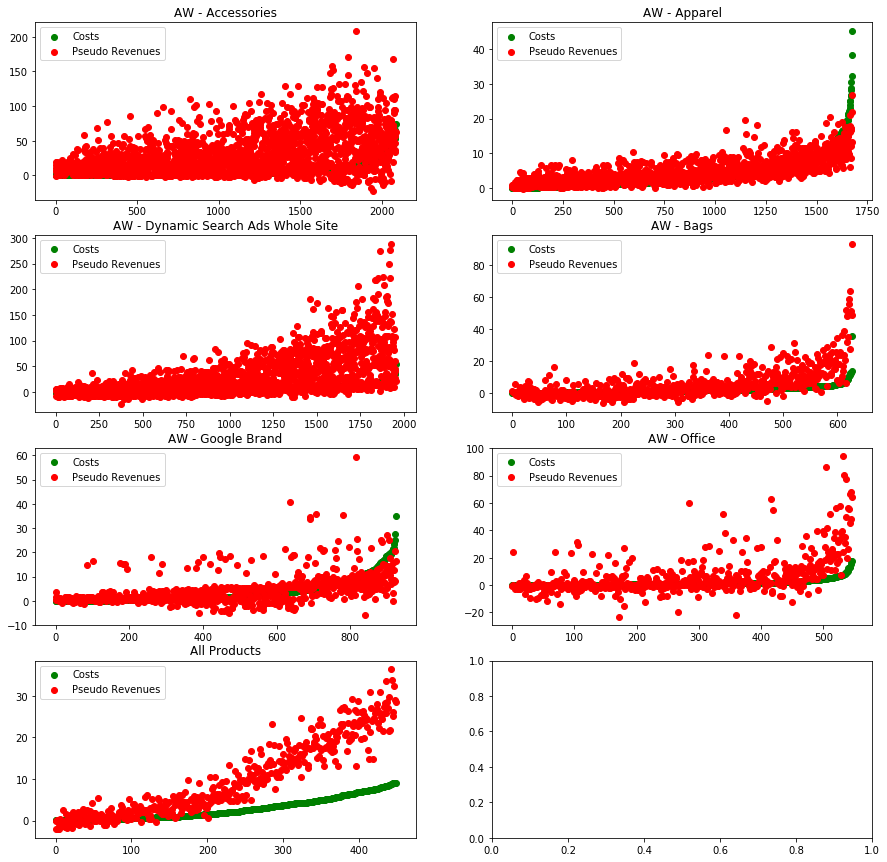

In [15]:
scatterRevenues(sumPredictedDfManyF)

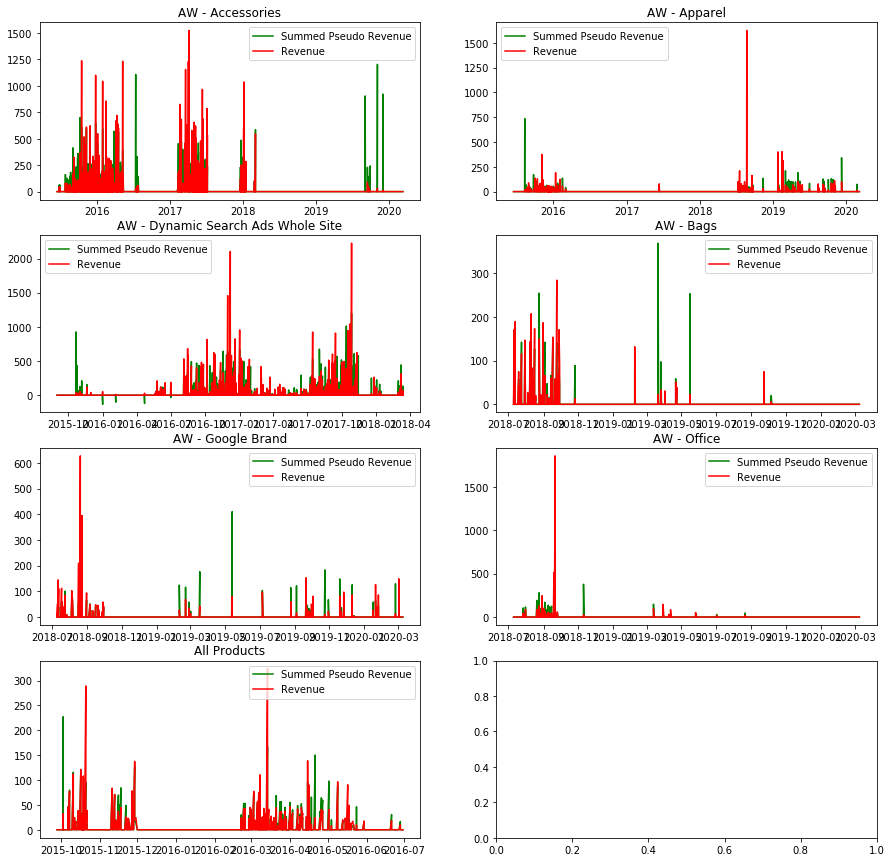

In [16]:
plotSummedRevenues(sumPredictedDfManyF)

In [17]:
display(getOverallError(sumPredictedDfManyF))

,Campaign,Sum Revenues,Sum Pseudo Revenues,Avg Revenue,Avg Diff Error (L1),Avg Relative (%)
0,AW - Accessories,63700.710938,31847.683594,140.930771,79.961 +/- 157.149,36.199081
1,AW - Apparel,9104.169922,1238.440186,65.972244,54.918 +/- 152.780,45.427972
2,AW - Bags,3721.279785,1072.915283,71.563072,41.938 +/- 62.401,36.949369
3,AW - Dynamic Search Ads Whole Site,57540.269531,30122.382812,150.628983,84.300 +/- 140.185,35.883252
4,AW - Google Brand,4122.770020,1117.416138,73.620895,55.987 +/- 95.547,43.197064
5,AW - Office,4269.280273,1386.404541,118.591118,104.923 +/- 268.067,46.942332
6,All Products,4502.509766,1890.443237,41.307430,16.709 +/- 32.935,28.800756


In [18]:
trainDfAllFeatures = pd.get_dummies(trainDf, columns=["Device Category"])
for col in trainDfAllFeatures:
    if col == "Bucket Index":
        continue
    try:
        trainDfAllFeatures[col] = trainDfAllFeatures[col].astype(np.float32)
    except Exception:
        pass
Stats = getMinMax(trainDfAllFeatures)

features = ["Cost", "Device Category_desktop", "Device Category_mobile", "Device Category_tablet", \
            "Users", "Sessions", "Bounces", "Transactions", "Product Detail Views", \
            "Product Adds To Cart", "Product Checkouts", "Total Unique Searches", \
            "New Users", "Session Duration (s)", "Impressions", "Clicks"]
models, errors = trainAllCampaignsLR(trainDfAllFeatures.reset_index(drop=True).copy(), Stats, LinearRegression, features=features)
display(pd.DataFrame(errors.items(), columns=["Campaign", "Error (L1)"]))

predictedDfAllF = createPseudoRevenues(models, trainDfAllFeatures, Stats, features=features)
sumPredictedDfAllF = createSumPredictedPseudoRevenue(predictedDfAllF)

,Campaign,Error (L1)
0,AW - Accessories,24.384892
1,AW - Apparel,5.143252
2,AW - Dynamic Search Ads Whole Site,21.330929
3,AW - Bags,5.947745
4,AW - Google Brand,4.973777
5,AW - Office,9.502907
6,All Products,5.990456


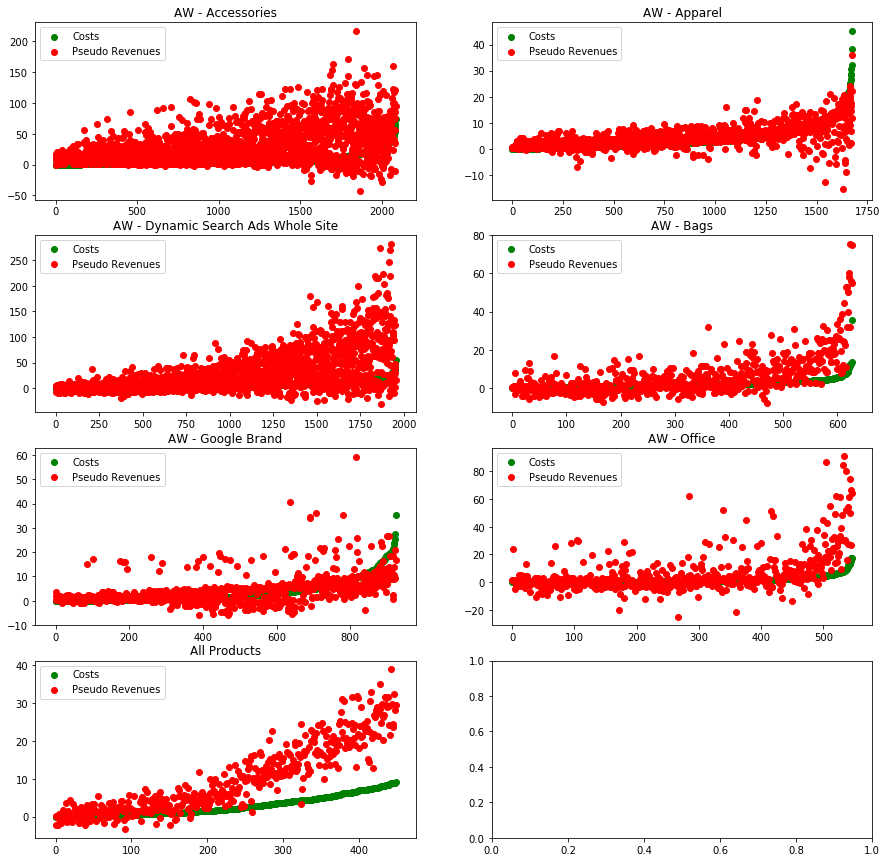

In [19]:
scatterRevenues(sumPredictedDfAllF)

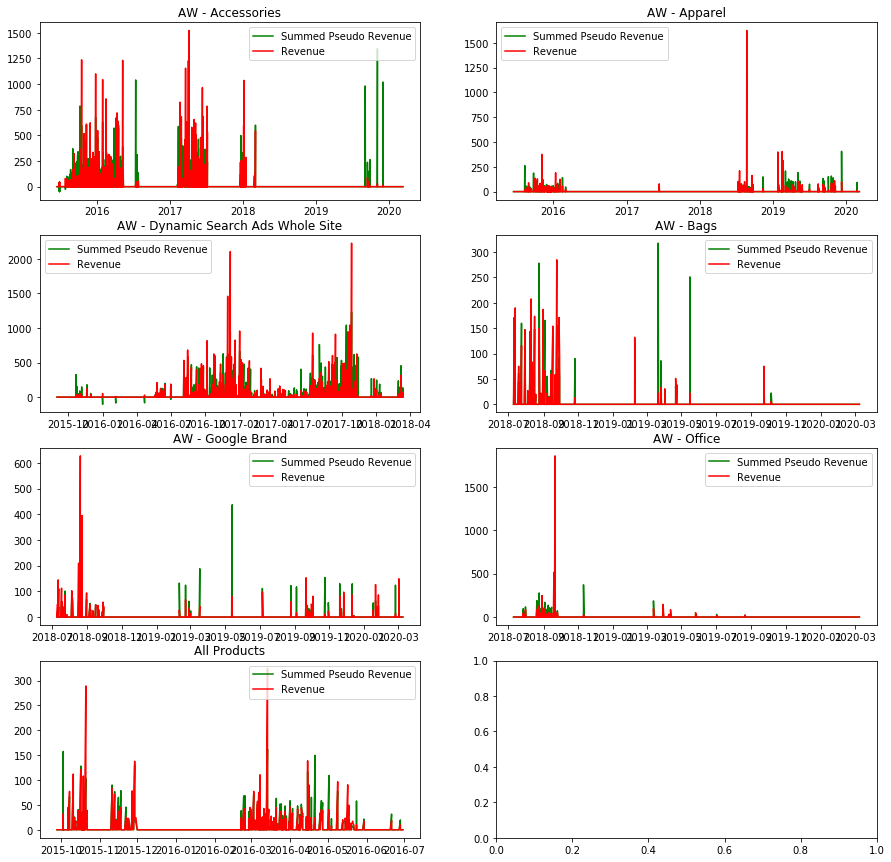

In [20]:
plotSummedRevenues(sumPredictedDfAllF)

In [21]:
display(getOverallError(sumPredictedDfAllF))

,Campaign,Sum Revenues,Sum Pseudo Revenues,Avg Revenue,Avg Diff Error (L1),Avg Relative (%)
0,AW - Accessories,63700.710938,31896.515625,140.930771,82.068 +/- 160.706,36.801907
1,AW - Apparel,9104.169922,1237.510498,65.972244,52.722 +/- 143.318,44.418181
2,AW - Bags,3721.279785,1069.131958,71.563072,41.029 +/- 58.280,36.440144
3,AW - Dynamic Search Ads Whole Site,57540.269531,30252.556641,150.628983,82.598 +/- 133.441,35.415363
4,AW - Google Brand,4122.770020,1116.369873,73.620895,56.066 +/- 96.272,43.231762
5,AW - Office,4269.280273,1391.857178,118.591118,102.541 +/- 267.688,46.370972
6,All Products,4502.509766,1904.934082,41.307430,16.545 +/- 29.504,28.598295
